<a href="https://colab.research.google.com/github/shaswatgithub/FACT-FILTER/blob/main/FACT_FILTER_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy scikit-learn nltk

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


#### Task 1: Data Loading and Exploring

In [ ]:
import pandas as pd

# Load the CSV files
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

# Display the first few rows of each dataframe
print("Fake News DataFrame:")
print(fake_df.head())

print("\nTrue News DataFrame:")
print(true_df.head())

# Example analysis: Word count
fake_df['word_count'] = fake_df['text'].apply(lambda x: len(str(x).split()))
true_df['word_count'] = true_df['text'].apply(lambda x: len(str(x).split()))

# Display basic statistics
print("\nFake News Word Count Statistics:")
print(fake_df['word_count'].describe())

print("\nTrue News Word Count Statistics:")
print(true_df['word_count'].describe())


Fake News DataFrame:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  

True News DataFrame:
                                               title  \
0  As U.S. budget fight looms, Republican

#### Task 2: Data Preprocessing

##### a) and b) Data Cleaning and Missing Values Handling

In [ ]:
import pandas as pd
import re


# Remove None values
fake_df.dropna(subset=['text'], inplace=True)
true_df.dropna(subset=['text'], inplace=True)

# Convert to lowercase
fake_df['text'] = fake_df['text'].str.lower()
true_df['text'] = true_df['text'].str.lower()

# Remove punctuation
fake_df['text'] = fake_df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
true_df['text'] = true_df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))


##### c) Data tokenization

In [ ]:
from nltk.tokenize import word_tokenize

fake_df['tokens'] = fake_df['text'].apply(word_tokenize)
true_df['tokens'] = true_df['text'].apply(word_tokenize)


##### d) Stop Word Removal

In [ ]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

fake_df['tokens'] = fake_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
true_df['tokens'] = true_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])


##### e) Apply Stemming and Lemmatization

In [ ]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nitis\AppData\Roaming\nltk_data...


True

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

fake_df['stemmed'] = fake_df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])
true_df['stemmed'] = true_df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

fake_df['lemmatized'] = fake_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
true_df['lemmatized'] = true_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


##### f) Data Vectorization using TF-IDF


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens back into string for TF-IDF
fake_df['lemmatized_text'] = fake_df['lemmatized'].apply(lambda x: ' '.join(x))
true_df['lemmatized_text'] = true_df['lemmatized'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(max_features=10000, max_df=0.95, min_df=2)

fake_tfidf_matrix = vectorizer.fit_transform(fake_df['lemmatized_text'])
true_tfidf_matrix = vectorizer.transform(true_df['lemmatized_text'])


print(vectorizer.get_feature_names_out())

# Initially I tried to fit the vectorizer separately on both dataframes,resulting in very large and different vocabulary sizes,
#leading to a MemoryError.

# This approach limits the vocabulary size with parameters (max_features, max_df, min_df)
# and avoids converting the sparse matrix to a dense array, reducing memory usage.

#### Task 3: Model Training

##### a) Train various Machine Learning Models - Logistic Regression, Random Forest, Decision Tree, Gradient Boosting and Hyperparameters tuning

##### Step i) Split Data into Training and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

# Combine fake and true data
fake_df['label'] = 0
true_df['label'] = 1
combined_df = pd.concat([fake_df, true_df])

X = combined_df['lemmatized_text']
y = combined_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


##### Step ii) Vectorize text data

In [ ]:
# Fit the vectorizer on the training data and transform both train and test sets
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


##### Step iii) Train and Evaluate Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [ ]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg_params = {'C': [0.1, 1, 10]}
log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5)
log_reg_grid.fit(X_train_tfidf, y_train)
log_reg_best = log_reg_grid.best_estimator_
print("Logistic Regression best parameters:", log_reg_grid.best_params_)
print("Logistic Regression classification report:")
print(classification_report(y_test, log_reg_best.predict(X_test_tfidf)))


Logistic Regression best parameters: {'C': 10}
Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
# Random Forest
rf = RandomForestClassifier()
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_grid = GridSearchCV(rf, rf_params, cv=5)
rf_grid.fit(X_train_tfidf, y_train)
rf_best = rf_grid.best_estimator_
print("Random Forest best parameters:", rf_grid.best_params_)
print("Random Forest classification report:")
print(classification_report(y_test, rf_best.predict(X_test_tfidf)))


Random Forest best parameters: {'max_depth': None, 'n_estimators': 100}
Random Forest classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
# Decision Tree
dt = DecisionTreeClassifier()
dt_params = {'max_depth': [None, 10, 20]}
dt_grid = GridSearchCV(dt, dt_params, cv=5)
dt_grid.fit(X_train_tfidf, y_train)
dt_best = dt_grid.best_estimator_
print("Decision Tree best parameters:", dt_grid.best_params_)
print("Decision Tree classification report:")
print(classification_report(y_test, dt_best.predict(X_test_tfidf)))


Decision Tree best parameters: {'max_depth': 10}
Decision Tree classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4696
           1       0.99      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Define the parameter grid
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5]
}

# Initialize the model
gb = GradientBoostingClassifier()

# Use RandomizedSearchCV for hyperparameter tuning
gb_random = RandomizedSearchCV(
    estimator=gb,
    param_distributions=gb_params,
    n_iter=8,  # Number of parameter settings that are sampled
    cv=2,       # Number of folds in cross-validation
    n_jobs=-1,  # Use all available CPU cores
    random_state=42
)

# Fit the model
gb_random.fit(X_train_tfidf, y_train)

# Get the best model
gb_best = gb_random.best_estimator_

# Print the best parameters and classification report
print("Gradient Boosting best parameters:", gb_random.best_params_)
print("Gradient Boosting classification report:")
print(classification_report(y_test, gb_best.predict(X_test_tfidf)))


Gradient Boosting best parameters: {'n_estimators': 200, 'learning_rate': 0.1}
Gradient Boosting classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       0.99      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



#### Task 4) Model Evaluation
#### Use all the appropriate metrics for evaluation and  Compare the performance of all models.


##### To thoroughly evaluate the performance of our models, I'll use various metrics: accuracy, precision, recall, F1-score, ROC-AUC score, and confusion matrices.

In [ ]:
!pip install matplotlib
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ------------ --------------------------- 92.2/294.9 kB 2.6 MB/s eta 0:00:01
   -------------------------- ------------- 194.6/294.9 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 3.0 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, roc_auc, cm

# Evaluate each model
models = {'Logistic Regression': log_reg_best,
          'Random Forest': rf_best,
          'Decision Tree': dt_best,
          'Gradient Boosting': gb_best}

results = {}

for model_name, model in models.items():
    accuracy, precision, recall, f1, roc_auc, cm = evaluate_model(model, X_test_tfidf, y_test)
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': cm
    }

# Print evaluation metrics
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1-score: {metrics['F1-score']:.4f}")
    print(f"ROC-AUC: {metrics['ROC-AUC']:.4f}")
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])
    print("\n")


Model: Logistic Regression
Accuracy: 0.9938
Precision: 0.9925
Recall: 0.9944
F1-score: 0.9935
ROC-AUC: 0.9998
Confusion Matrix:
[[4664   32]
 [  24 4260]]


Model: Random Forest
Accuracy: 0.9984
Precision: 0.9984
Recall: 0.9984
F1-score: 0.9984
ROC-AUC: 0.9999
Confusion Matrix:
[[4689    7]
 [   7 4277]]


Model: Decision Tree
Accuracy: 0.9957
Precision: 0.9937
Recall: 0.9972
F1-score: 0.9955
ROC-AUC: 0.9952
Confusion Matrix:
[[4669   27]
 [  12 4272]]


Model: Gradient Boosting
Accuracy: 0.9960
Precision: 0.9949
Recall: 0.9967
F1-score: 0.9958
ROC-AUC: 0.9990
Confusion Matrix:
[[4674   22]
 [  14 4270]]




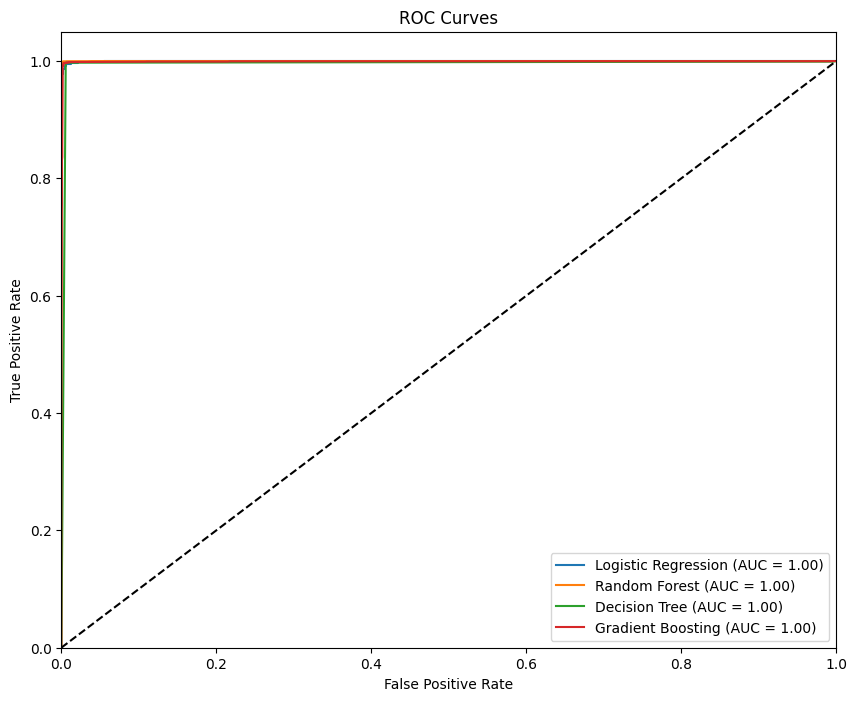

In [ ]:
# Plot ROC curves for each model
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()


##### This ROC curve demonstrates that all four models (Logistic Regression, Random Forest, Decision Tree, and Gradient Boosting) are performing perfectly on the given dataset, with an AUC of 1.00, indicating that they all have perfect classification abilities on this specific dataset. This could be a sign of overfitting, where the models perform exceptionally well on the training/testing data but may not generalize to new, unseen data.

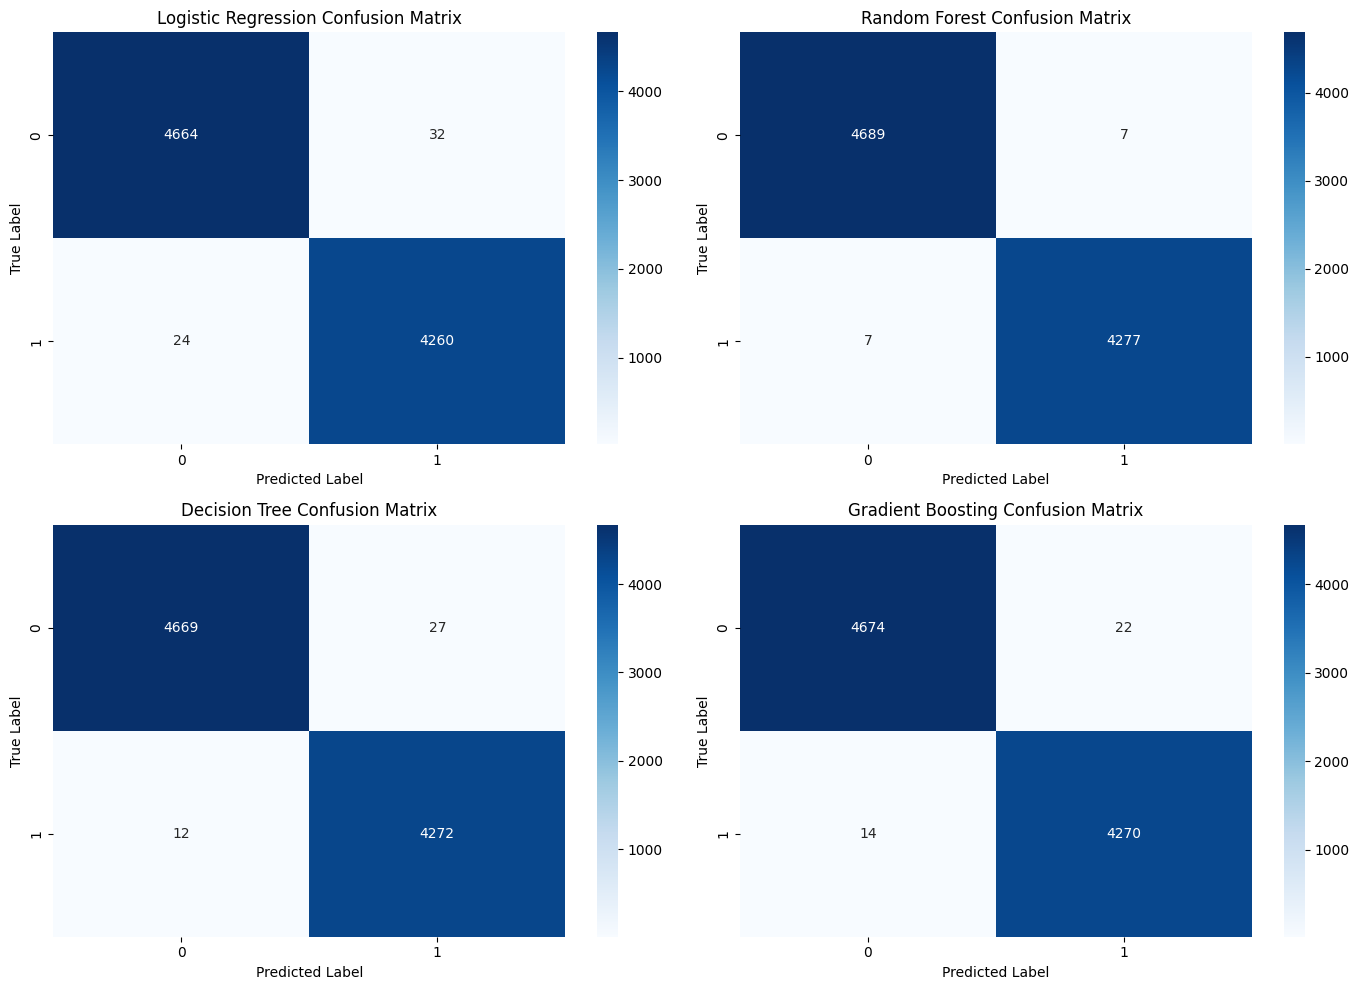

In [ ]:
# Visualize confusion matrices for each model
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, (model_name, metrics) in zip(axes.flatten(), results.items()):
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()
